<a href="https://colab.research.google.com/github/vatsalyatandon/tensorflow-examples/blob/master/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Predict Fuel Efficiency
!pip install -q seaborn

In [41]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


In [42]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [43]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

In [0]:
dataset.isna().sum()
dataset = dataset.dropna()

In [45]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.head()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  USA  Europe  Japan  
0          70  1.0     0.0    0.0  
1          70  1.0     0.0    0.0  
2          70  1.0     0.0    0.0  
3          70  1.0     0.0    0.0  
4          70  1.0     0.0    0.0

In [0]:
train = dataset.sample(frac=0.8, random_state=0)
test = dataset.drop(train.index)

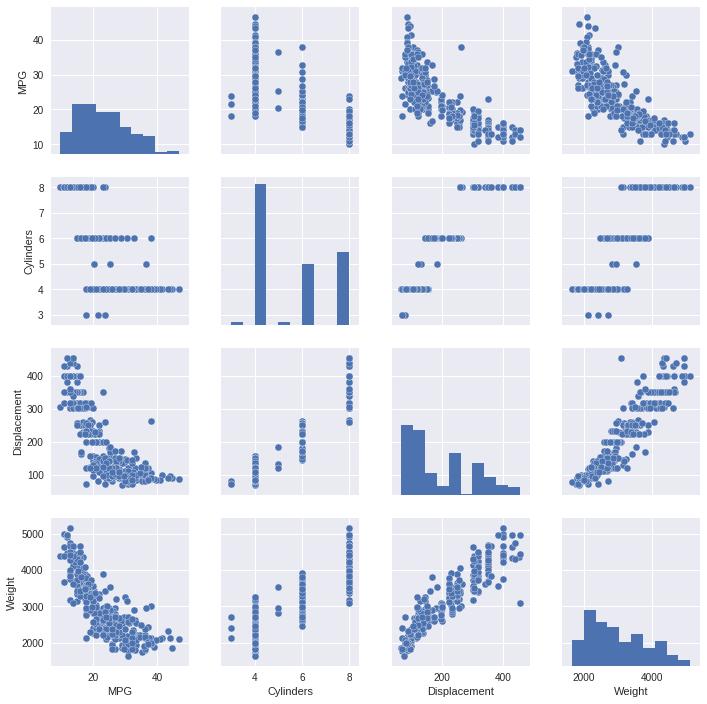

In [47]:
sns.pairplot(train[["MPG", "Cylinders", "Displacement", "Weight"]])

In [48]:
train_stats = train.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe           0.00     1.0  
Japan            0.00     1.0

In [0]:
train_labels = train.pop('MPG')
test_labels = test.pop('MPG')

In [0]:
def norm(x):
  return (x-train_stats['mean'])/train_stats['std']
normed_train = norm(train)
normed_test = norm(test)

In [0]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train.keys())]),
      layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(1)
  ])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  
  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [0]:
model = build_model()

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [54]:
example_batch = normed_train[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.6341677 ],
       [ 0.07665203],
       [ 0.30667275],
       [ 0.599246  ],
       [-0.41286153],
       [ 0.02689584],
       [-0.4025515 ],
       [ 0.13079554],
       [-0.00379664],
       [-0.2063883 ]], dtype=float32)

In [55]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
EPOCHS = 1000

history = model.fit(
  normed_train, train_labels, epochs = EPOCHS, validation_split = 0.2, verbose=0, callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [56]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss  mean_absolute_error  mean_squared_error  val_loss  \
995  2.561634             1.006170            2.561634  9.372001   
996  3.003430             1.159696            3.003430  9.025519   
997  2.613156             1.027094            2.613156  8.986614   
998  2.726763             1.050457            2.726763  8.860740   
999  2.824637             1.081116            2.824637  8.645184   

     val_mean_absolute_error  val_mean_squared_error  epoch  
995                 2.278485                9.372001    995  
996                 2.267422                9.025518    996  
997                 2.266089                8.986614    997  
998                 2.255313                8.860741    998  
999                 2.212843                8.645185    999

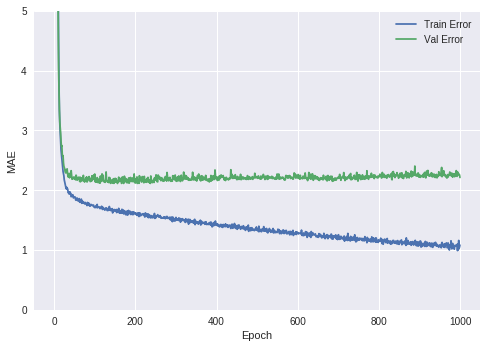

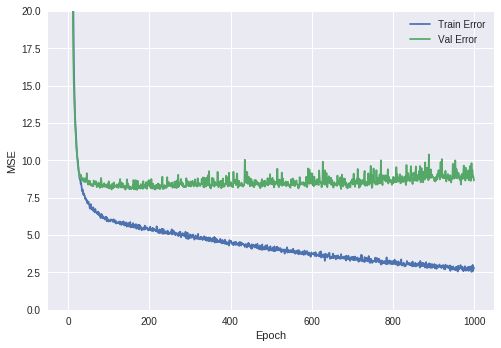

In [58]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAE')
  plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'], label='Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()
plot_history(history)


.....................................................................................

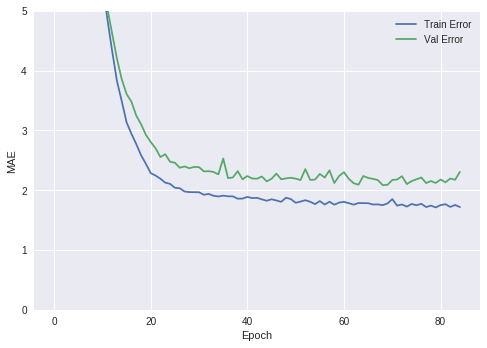

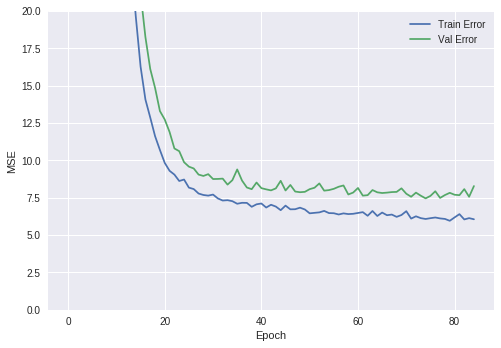

In [59]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(normed_train, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

In [61]:
loss, mae, mse = model.evaluate(normed_test, test_labels, verbose = 0)
print("Testing set MAE", (mae))

Testing set MAE 1.7428943


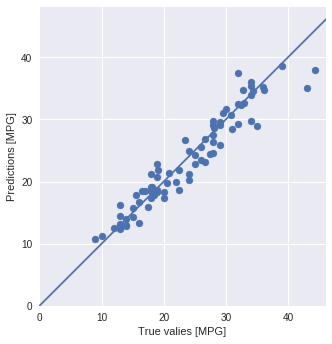

In [63]:
test_predictions = model.predict(normed_test).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

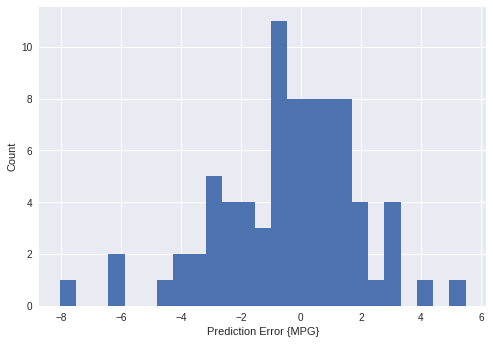

In [64]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error {MPG}")
_ = plt.ylabel("Count")